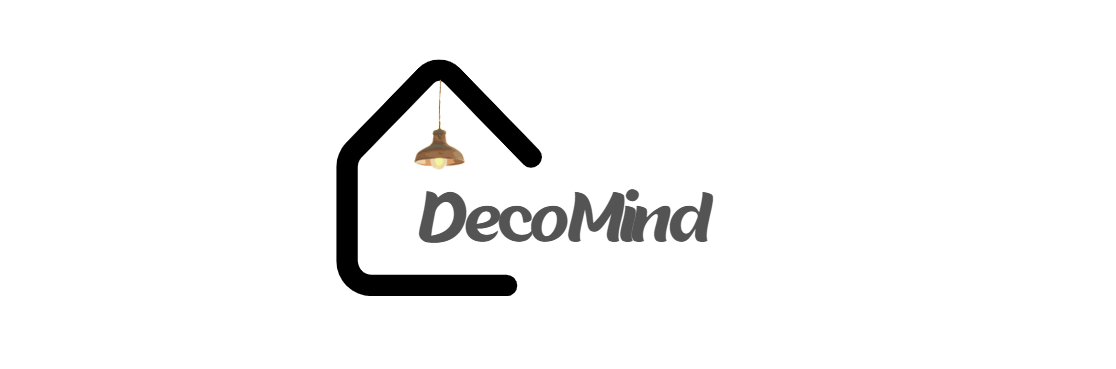

# **DecoMind:**It is a system that assists individuals in designing their rooms or visualizing furniture within their space before completing a purchase.


In [ ]:
# Install required packages
!pip install rembg
!pip install onnxruntime
!pip install clip
!pip install --upgrade diffusers


In [ ]:
#import the necessary libraries
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFilter
import torch
import os
from transformers import CLIPProcessor, CLIPModel
from torchvision import models, transforms
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from rembg import remove
from diffusers import StableDiffusionPipeline, ControlNetModel

In [ ]:
!unzip -q '/content/ikea_filtered.zip' -d '/content/unzipped_data/' #the dataset of the store

In [ ]:
# Remove the background of the images of furnitures
def remove_background(image_path):
    with open(image_path, "rb") as i:
        input_image = i.read()
    output_image = remove(input_image)
    out_path = f"removed_{os.path.basename(image_path)}"
    with open(out_path, "wb") as o:
        o.write(output_image)
    return out_path




In [ ]:
# select the suitable furnitures from the dataset
def select_furniture1(folder_path, room_type, style, furniture_types, top_k=3):
    """
    Selects relevant furniture items based on room type, style, and specified furniture types.
    Ensures that each furniture type has a unique image.
    """
    # Load the CLIP model and processor
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    selected_paths = []  # List to store selected furniture paths

    # Iterate over each furniture type to select the best matching image
    for furniture_type in furniture_types:
        # Create the prompt for the current furniture type
        prompt = f"{style} {room_type} {furniture_type} furniture"

        # Tokenize and process the text using CLIPProcessor
        inputs = clip_processor(text=[prompt], return_tensors="pt", padding=True).to(device)

        # Collect all files in the directory
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # List to store image features and similarities for this furniture type
        furniture_dict = []

        # Iterate through all images and calculate their similarity with the prompt
        for path in image_paths:
            try:
                # Load and preprocess the image
                image = Image.open(path).convert("RGB")
                image_input = clip_processor(images=image, return_tensors="pt").to(device)

                # Get image features from CLIP
                with torch.no_grad():
                    image_features = clip_model.get_image_features(**image_input)

                # Get text features for the prompt
                text_features = clip_model.get_text_features(**inputs)

                # Normalize the features (important for cosine similarity)
                image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

                # Calculate cosine similarity
                similarity = torch.cosine_similarity(image_features, text_features)
                similarity_value = similarity.item()

                # Append the image path and its similarity
                furniture_dict.append((path, similarity_value))

            except Exception as e:
                print(f"❌ Error processing {path}: {e}")

        # Sort the results by similarity
        furniture_dict.sort(key=lambda x: x[1], reverse=True)

        # Select the best match that has not been selected before
        for path, _ in furniture_dict:
            if path not in selected_paths:
                selected_paths.append(path)
                break

    # Debugging information
    print(f"Total paths found: {len(image_paths)}")
    print(f"Paths before limit: {image_paths}")
    print(f"Final selected furniture paths (top {len(furniture_types)}): {selected_paths}")
    print(f"Length of selected paths: {len(selected_paths)}")  # Debugging print to ensure correct selections

    return selected_paths  # Return only the selected image paths

# Adjust the size of furnitures
def resize_furniture_for_layout(furniture_img, room_dimensions, layout_size=(512, 512)):
    room_m2 = room_dimensions[0] * room_dimensions[1]
    scale_factor = max(0.15, min(0.35, 20 / room_m2))
    new_w = int(layout_size[0] * scale_factor)
    new_h = int(layout_size[1] * scale_factor)
    return furniture_img.resize((new_w, new_h))


In [ ]:
# Generate the final image

def generate_layout_image(room_dimensions, window_position, door_position):
    SCALE = 100
    width, height = room_dimensions
    layout_w = int(width * SCALE)
    layout_h = int(height * SCALE)
    img = Image.new("RGB", (layout_w, layout_h), color="#e8e8e8")
    draw = ImageDraw.Draw(img)

    # Drawing room boundaries
    draw.rectangle([0, 0, layout_w - 1, layout_h - 1], outline="black", width=3)

    # Add window
    window_width = 60  # Example window width
    window_height = 10  # Example window height
    if window_position == "north":
        # Window on the north wall, centered
        window_x = (layout_w - window_width) // 2
        window_y = 0  # Top of the room
        draw.rectangle([window_x, window_y, window_x + window_width, window_y + window_height], fill="blue")
    elif window_position == "south":
        # Window on the south wall, centered
        window_x = (layout_w - window_width) // 2
        window_y = layout_h - window_height  # Bottom of the room
        draw.rectangle([window_x, window_y, window_x + window_width, window_y + window_height], fill="blue")
    elif window_position == "west":
        # Window on the west wall, centered
        window_x = 0  # Left side of the room
        window_y = (layout_h - window_height) // 2
        draw.rectangle([window_x, window_y, window_x + window_width, window_y + window_height], fill="blue")
    elif window_position == "east":
        # Window on the east wall, centered
        window_x = layout_w - window_width  # Right side of the room
        window_y = (layout_h - window_height) // 2
        draw.rectangle([window_x, window_y, window_x + window_width, window_y + window_height], fill="blue")

    # Add door
    door_width = 20  # Example door width
    door_height = 40  # Example door height
    if door_position == "west":
        # Door on the west wall, centered
        door_x = 0  # Left side of the room
        door_y = (layout_h - door_height) // 2
        draw.rectangle([door_x, door_y, door_x + door_width, door_y + door_height], fill="red")
    elif door_position == "east":
        # Door on the east wall, centered
        door_x = layout_w - door_width  # Right side of the room
        door_y = (layout_h - door_height) // 2
        draw.rectangle([door_x, door_y, door_x + door_width, door_y + door_height], fill="red")
    elif door_position == "north":
        # Door on the north wall, centered
        door_x = (layout_w - door_width) // 2
        door_y = 0  # Top of the room
        draw.rectangle([door_x, door_y, door_x + door_width, door_y + door_height], fill="red")
    elif door_position == "south":
        # Door on the south wall, centered
        door_x = (layout_w - door_width) // 2
        door_y = layout_h - door_height  # Bottom of the room
        draw.rectangle([door_x, door_y, door_x + door_width, door_y + door_height], fill="red")

    return img.resize((512, 512))  # Resize for better viewing




In [ ]:
def place_furniture(layout, furniture_paths, room_dimensions, window_pos, door_pos):
    layout = layout.convert("RGBA")
    placed_positions = []  # Track placed positions to avoid overlap
    for path in furniture_paths:
        try:
            clean_path = remove_background(path)
            furniture = Image.open(clean_path).convert("RGBA")
            furniture = resize_furniture_for_layout(furniture, room_dimensions, layout_size=layout.size)

            # Get a unique position for the furniture
            x, y, width, height = get_smart_position(path, layout.size, window_pos, door_pos, placed_positions)

            # Add shadow for depth
            shadow = furniture.copy().filter(ImageFilter.GaussianBlur(5))
            layout.alpha_composite(shadow, (x + 8, y + 8))
            layout.alpha_composite(furniture, (x, y))

            placed_positions.append((x, y, width, height))  # Save positions
        except Exception as e:
            print(f" Error placing furniture {path}: {e}")

    return layout.convert("RGB"), placed_positions


# get a samrt position for each furniture on the layout
def get_smart_position(furniture_name, layout_size, window_pos, door_pos, placed_furniture):
    w, h = layout_size

    # Check for window and door positions
    avoid_zones = []
    if window_pos == "north":
        avoid_zones.append(((w // 2 - 60, 0), (w // 2 + 60, 30)))
    elif window_pos == "south":
        avoid_zones.append(((w // 2 - 60, h - 30), (w // 2 + 60, h)))
    if door_pos == "west":
        avoid_zones.append(((0, h // 2 - 60), (30, h // 2 + 60)))
    elif door_pos == "east":
        avoid_zones.append(((w - 30, h // 2 - 60), (w, h // 2 + 60)))

    # Smart spots for furniture types
    smart_spots = {
        "bed": (w // 2 - 100, h - 200, 200, 100),
        "cabinet": (30, 30, 100, 200),
        "chair": (w // 2 + 30, h // 2, 50, 50),
        "clock": (w - 80, 30, 40, 40),
        "couch": (w // 4, h // 2 + 60, 150, 75),
        "oven": (w - 120, h - 120, 80, 80),
        "pillow": (w // 2 - 100, h // 2 + 100, 50, 50),
        "table": (w // 3, h // 3, 100, 50)
    }

    # Default size if not found in smart_spots
    x, y, width, height = smart_spots.get(furniture_name, (random.randint(50, max(w - 150, 50)), random.randint(50, max(h - 150, 50)), 100, 100))

    #  Check if the selected position overlaps with already placed furniture
    def is_overlapping(x, y, width, height):
        for (px, py, pwidth, pheight) in placed_furniture:
            if not (x + width < px or x > px + pwidth or y + height < py or y > py + pheight):
                return True
        return False

    # Ensure no overlap with other furniture
    max_attempts = 10
    attempts = 0
    while is_overlapping(x, y, width, height) and attempts < max_attempts:
        x, y = random.randint(50, max(w - 150, 50)), random.randint(50, max(h - 150, 50))
        attempts += 1

    # If max attempts reached, use the last valid position
    if attempts == max_attempts:
        print(f" Max attempts reached while placing {furniture_name}. Using last valid position.")

    # Add the position to the placed furniture
    placed_furniture.append((x, y, width, height))

    return x, y, width, height


In [ ]:
def generate_prompt(inputs, furniture_positions):
    width, height = inputs["room_dimensions"]
    furniture_list = ", ".join(inputs["furniture_types"])


    furniture_details = []
    for furniture_type, (x, y, w, h) in furniture_positions:
        furniture_details.append(f"Place a {furniture_type} at position ({x}, {y})")

    furniture_details_str = "; ".join(furniture_details)

    prompt = (
        f"A realistic {inputs['style']} {inputs['room_type']} interior with furniture placed based on the given layout image. "
        f"The room is {width}x{height} meters with a window on the {inputs['window_position']} wall and a door on the {inputs['door_position']} wall. "
        f"The furniture includes: {furniture_list}. "
        f"Ensure that each piece of furniture matches its exact appearance, including style, color, and material, as shown in the layout image. "
        f"Furniture placement details: {furniture_details_str}. "
        f"Make sure the furniture arrangement respects the provided layout and includes natural placement, ensuring furniture does not overlap. "
        f"Also, ensure the furniture is well-lit, placed according to the layout, with cozy and warm textures, just as they appear in the layout. "
        f"Additional considerations: {inputs['extra_description']}. "
        f"Be sure to consider room features like wall color, window and door placements, and ensure realistic lighting and shadows."
    )


    if len(prompt) > 350:
     prompt = prompt[:350]


    return prompt


In [ ]:
def generate_final_design_with_controlnet(layout_with_furniture, final_prompt, pipe, mask_image=None):
    if not isinstance(layout_with_furniture, Image.Image):
        raise ValueError("layout_with_furniture must be a PIL Image")

    # Ensure RGB format
    layout_rgb = layout_with_furniture.convert("RGB")

    result = pipe(
        prompt=final_prompt,
        image=layout_rgb,
        control_image=layout_rgb,  # IMPORTANT: for ControlNet
        mask_image=mask_image,     # Optional: only if using inpainting
        num_inference_steps=30,
        guidance_scale=8.0,
        controlnet_conditioning_scale=1.0,
    ).images[0]

    result.save("final_design.png")
    print("✅ Final design saved as final_design.png")


In [ ]:
# Load Stable Diffusion pipeline
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None
).to(device)

# ControlNet setup
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16)
controlnet.to(device)

# Create a pipe for Stable Diffusion with ControlNet
pipe.controlnet = controlnet

In [ ]:
def choose_from_list(title, options):
    print(f"\n📌 Choose {title} from the list below:")
    for i, option in enumerate(options):
        print(f"{i+1}. {option}")
    while True:
        try:
            choice = int(input(f"Enter {title} number (1-{len(options)}): "))
            if 1 <= choice <= len(options):
                return options[choice - 1]
            else:
                print("❌ Invalid number. Try again.")
        except ValueError:
            print("❌ Please enter a valid number.")

# Main execution pipeline
if __name__ == "__main__":

    # Folder with furniture images
    image_folder = "/content/unzipped_data/content/all_data_filtered"

    # Valid room types and styles
    valid_room_types = ["bathroom", "bedroom", "dinning", "kitchen", "livingroom"]
    valid_styles = [
        "asian", "coastal", "contemporary", "craftsman", "eclectic", "farmhouse",
        "french-country", "industrial", "mediterranean", "mid-century-modern",
        "modern", "rustic", "scandinavian", "shabby-chic-style", "southwestern",
        "traditional", "transitional", "tropical", "victorian"
    ]

    # User selections
    room_type = choose_from_list("room type", valid_room_types)
    style = choose_from_list("style", valid_styles)

    # Other inputs
    room_dimensions = tuple(map(int, input("Enter room dimensions (width height) seperated by space: ").split()))
    window_position = input("Enter window position (north, south, east, west): ").strip().lower()
    door_position = input("Enter door position (north, south, east, west): ").strip().lower()
    extra_description = input("Enter any extra description (optional): ").strip()
    furniture_types = input("Enter furniture types separated by commas (e.g., bed, couch): ").split(",")
    furniture_types = [f.strip().lower() for f in furniture_types]

    # Combine all inputs
    inputs = {
        "room_type": room_type,
        "style": style,
        "room_dimensions": room_dimensions,
        "window_position": window_position,
        "door_position": door_position,
        "extra_description": extra_description,
        "furniture_types": furniture_types
    }

    # Select furniture paths
    furniture_paths = select_furniture1(image_folder, room_type=inputs["room_type"], style=inputs["style"],
                                        furniture_types=inputs["furniture_types"], top_k=2)

    # Generate layout and place furniture
    layout = generate_layout_image(inputs["room_dimensions"], inputs["window_position"], inputs["door_position"])
    layout_with_furniture, placed_positions = place_furniture(layout, furniture_paths, inputs["room_dimensions"],
                                                               inputs["window_position"], inputs["door_position"])
    layout_with_furniture.save("check_layout.png")

    # Get prompt
    furniture_positions = list(zip(inputs["furniture_types"], placed_positions))
    final_prompt = generate_prompt(inputs, furniture_positions)

In [ ]:
# Define a utility function to truncate long prompts

from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def truncate_prompt(prompt):
    tokens = tokenizer(prompt, return_tensors="pt")["input_ids"][0]
    if len(tokens) > 77:
        prompt = tokenizer.decode(tokens[:77], skip_special_tokens=True)
    return prompt


In [ ]:
final_prompt= truncate_prompt(final_prompt)

 # Print the generated prompt for debugging purposes
    print("\n📝 Prompt:\n", final_prompt)

In [ ]:
#generate the final design
generate_final_design_with_controlnet(layout_with_furniture, final_prompt, pipe)

In [ ]:
#Evaluation process
import zipfile

def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted: {extract_to}")

unzip_dataset("/content/archive (2).zip", "/content/rooms_data")
#***This dataset is subject to usage rights. Please verify before use***
unzip_dataset("//content/archive (3).zip", "/content/styles_data")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator instances
room_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Rescale images
style_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Rescale images

# Define room_generator and style_generator before validation generators
room_generator = room_datagen.flow_from_directory(
    "/content/rooms_data/House_Room_Dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set this to training subset for room_generator
)

style_generator = style_datagen.flow_from_directory(
    "/content/styles_data/dataset_train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set this to training subset for style_generator
)

room_validation_generator = room_datagen.flow_from_directory(
    "//content/rooms_data/House_Room_Dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set this to validation subset
)

style_validation_generator = style_datagen.flow_from_directory(
    "/content/styles_data/dataset_train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set this to validation subset
)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_transfer_learning_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Freeze layers of base model for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
room_model = create_transfer_learning_model(num_classes=room_generator.num_classes)
style_model = create_transfer_learning_model(num_classes=style_generator.num_classes)

# Train models
room_model.fit(room_generator, validation_data=room_validation_generator, epochs=5)
style_model.fit(style_generator, validation_data=style_validation_generator, epochs=5)


In [ ]:
# Classification function
def classify_generated_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = class_labels[np.argmax(prediction)]

    return predicted_class

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
# Get class labels
room_labels = list(room_generator.class_indices.keys())
style_labels = list(style_generator.class_indices.keys())

# Predict room type and style for generated image
generated_image_path = "/content/final_design.png"
predicted_room = classify_generated_image(generated_image_path, room_model, room_labels)
predicted_style = classify_generated_image(generated_image_path, style_model, style_labels)

# Compute the final score
def compute_final_score(user_inputs, predicted_room, predicted_style):
    room_match = int(predicted_room.lower() == inputs['room_type'].lower())
    style_match = int(predicted_style.lower() == inputs['style'].lower())

    print("\n Evaluation Report:")
    print(f"Room Type Match: {'✅' if room_match else '❌'}")
    print(f"Style Match: {'✅' if style_match else '❌'}")

    final_score = (room_match + style_match) / 2
    print(f"\n Final Score: {final_score:.2f}")
    return final_score

In [ ]:
compute_final_score(inputs, predicted_room, predicted_style)